
*Machine Translation Jupyter Notebook.  (c) 2021 Georgia Tech*

*Copyright 2021, Georgia Institute of Technology (Georgia Tech) <br>Atlanta, Georgia 30332<br>All Rights Reserved*

*Georgia Tech asserts copyright ownership of this template and all derivative works, including solutions to the projects assigned in this course. Students and other users of this template code are advised not to share it with others or to make it available on publicly viewable websites including repositories such as Github, Bitbucket, and Gitlab.  This copyright statement should not be removed or edited.*

*Sharing solutions with current or future students of CS 7643 Deep Learning is prohibited and subject to being investigated as a GT honor code violation.*

*DO NOT EDIT ANYTHING ABOVE THIS LINE*

# Machine Translation with Seq2Seq and Transformers
In this exercise you will implement a [Sequence to Sequence(Seq2Seq)](https://arxiv.org/abs/1703.03906) and a [Transformer](https://arxiv.org/pdf/1706.03762.pdf) model and use them to perform machine translation.

**A quick note: if you receive the following TypeError "super(type, obj): obj must be an instance or subtype of type", try re-importing that part or restarting your kernel and re-running all cells.** Once you have finished making changes to the model constuctor, you can avoid this issue by commenting out all of the model instantiations after the first (e.g. lines starting with "model = TransformerTranslator(*args, **kwargs)").

# ** 1: Introduction**

## Multi30K: Multilingual English-German Image Descriptions

[Multi30K](https://github.com/multi30k/dataset) is a dataset for machine translation tasks. It is a multilingual corpus containing English sentences and their German translation. In total it contains 31014 sentences(29000 for training, 1014 for validation, and 1000 for testing).
As one example:

En: `Two young, White males are outside near many bushes.`

De: `Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.`

You can read more info about the dataset [here](https://arxiv.org/abs/1605.00459). The following parts of this assignment will be based on this dataset.

**Notice: For the following assignment, we strongly recommend you to work in a virtual python environment. We recommend Anaconda, a powerful environment control tool. You can download it [here](https://www.anaconda.com/products/individual)**.

## 1.1: Prerequisites
Before you start this assignment, you need to have all required packages installed either on the terminal you are using, or in the virtual environment. Please make sure you have the following package installed:

`Torch Tqdm, Numpy`

You can first check using either `pip freeze` in terminal or `conda list` in conda environment. Then run the following code block to make sure they can be imported.

In [22]:
# Just run this block. Please do not modify the following code.
import math
import time
import io
import numpy as np
import csv
from IPython.display import Image

# Pytorch package
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from collections import Counter
from torch.nn.utils.rnn import pad_sequence

# Tqdm progress bar
from tqdm import tqdm_notebook, tqdm

# Code provide to you for training and evaluation
from utils import train, evaluate, set_seed_nb, unit_test_values, deterministic_init, plot_curves

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
#%load_ext autoreload
#%autoreload 2

## **1.2: Preprocess Data**
You can now prepare the Just run the following code blocks. Read the comment and try to understand what they are for.

Now lets check your GPU availability and load some sanity checkers. By default you should be using your gpu for this assignment if you have one available.

In [4]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [3]:
!cat /proc/cpuinfo | grep 'model name'

'cat' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
# load checkers
d1 = torch.load('./data/d1.pt')
d2 = torch.load('./data/d2.pt')
d3 = torch.load('./data/d3.pt')
d4 = torch.load('./data/d4.pt')

In [13]:
import requests
import gzip
import os
from typing import List, Tuple

# Constants
MAX_LEN = 20
url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

def download_file(url: str, dest_folder: str) -> str:
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    filename = os.path.join(dest_folder, url.split('/')[-1])

    # Download the file
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
    else:
        raise Exception(f"Failed to download {url}")

    return filename

def extract_gzip(filepath: str) -> str:
    output_filepath = filepath[:-3]  # Remove .gz extension
    with gzip.open(filepath, 'rb') as f_in:
        with open(output_filepath, 'wb') as f_out:
            f_out.write(f_in.read())
    return output_filepath

# Download and extract files
def download_and_extract(urls: Tuple[str]) -> List[str]:
    filepaths = []
    for url in urls:
        filepath = download_file(url_base + url, 'data')
        extracted_filepath = extract_gzip(filepath)
        filepaths.append(extracted_filepath)
    return filepaths

# train_filepaths = download_and_extract(train_urls)
# val_filepaths = download_and_extract(val_urls)
# test_filepaths = download_and_extract(test_urls)

In [14]:
train_filepaths = ['data/train.de', 'data/train.en']
val_filepaths = ['data/val.de', 'data/val.en']
test_filepaths = ['data/test_2016_flickr.de', 'data/test_2016_flickr.en']

In [15]:
print (train_filepaths)
print (val_filepaths)
print (test_filepaths)

['data/train.de', 'data/train.en']
['data/val.de', 'data/val.en']
['data/test_2016_flickr.de', 'data/test_2016_flickr.en']


In [16]:
import io
import re
from typing import List

class Vocabulary:
    def __init__(self, min_freq: int = 2, specials: List[str] = None):
        if specials is None:
            specials = ['<unk>', '<pad>', '<sos>', '<eos>']
        self.stoi = {token: idx for idx, token in enumerate(specials)}
        self.itos = {idx: token for idx, token in enumerate(specials)}
        self.min_freq = min_freq

    def build_from_counter(self, counter: Counter):
        idx = len(self.stoi)
        for token, count in counter.items():
            if count >= self.min_freq and token not in self.stoi:
                self.stoi[token] = idx
                self.itos[idx] = token
                idx += 1

    def __len__(self):
        return len(self.stoi)

    def __getitem__(self, token: str) -> int:
        return self.stoi.get(token, self.stoi['<unk>'])

    def set_default_index(self, index: int):
        self.default_index = index

    def __call__(self, token: str) -> int:
        return self.stoi.get(token, self.default_index)

    def get_itos(self) -> dict:
        """Return the index-to-string mapping."""
        return self.itos


def simple_tokenizer(text: str) -> List[str]:
    # Use regex to split on whitespace and remove punctuation
    tokens = re.findall(r'\b\w+\b', text)
    return tokens



def build_vocab(filepath: str, tokenizer, max_vocab_size: int = 1000000) -> Vocabulary:
    counter = Counter()

    # Print a few lines from the file for debugging
    with io.open(filepath, encoding="utf8") as f:
        for i, string_ in enumerate(f):
            tokens = tokenizer(string_.lower())
            counter.update(tokens)


    vocab = Vocabulary(min_freq=2)  # Set min_freq to 2
    vocab.build_from_counter(counter)

    vocab.set_default_index(vocab['<unk>'])
    return vocab

# Example usage with the custom tokenizer

de_vocab = build_vocab(train_filepaths[0], simple_tokenizer)
en_vocab = build_vocab(train_filepaths[1], simple_tokenizer)

# Print vocabulary sizes
print(f"German Vocabulary Size: {len(de_vocab)}")
print(f"English Vocabulary Size: {len(en_vocab)}")

German Vocabulary Size: 7860
English Vocabulary Size: 5883


In [17]:
import io
import torch
from typing import List, Tuple

def data_process(filepaths: List[str]) -> List[Tuple[torch.Tensor, torch.Tensor]]:
    raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
    raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
    data = []

    for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
        raw_de_l = raw_de.lower()  # Turn German sentences to lower case
        raw_en_l = raw_en.lower()  # Turn English sentences to lower case

        # Tokenize using the simple tokenizer
        de_tokens = simple_tokenizer(raw_de_l)
        en_tokens = simple_tokenizer(raw_en_l)

        # Convert tokens to tensor using the vocabulary
        de_tensor = torch.tensor([de_vocab[token] for token in de_tokens], dtype=torch.long)
        en_tensor = torch.tensor([en_vocab[token] for token in en_tokens], dtype=torch.long)

        # Check length constraints
        if len(de_tensor) <= MAX_LEN - 2 and len(en_tensor) <= MAX_LEN - 2:
            data.append((de_tensor, en_tensor))

    return data

In [12]:
train_data = data_process(train_filepaths)
val_data = data_process(val_filepaths)
test_data = data_process(test_filepaths)

In [18]:
BATCH_SIZE = 128
PAD_IDX = de_vocab['<pad>']
SOS_IDX = de_vocab['<sos>']
EOS_IDX = de_vocab['<eos>']

In [19]:
def generate_batch(data_batch):

    de_batch, en_batch = [], []
    for (de_item, en_item) in data_batch:
          en_batch.append(torch.cat([torch.tensor([SOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
          de_batch.append(torch.cat([torch.tensor([SOS_IDX]), de_item, torch.tensor([EOS_IDX])], dim=0))
    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
    de_batch = pad_sequence(de_batch, padding_value=PAD_IDX)
    fix=torch.ones(MAX_LEN,en_batch.shape[1])
    two= pad_sequence([de_batch,en_batch, fix], padding_value=PAD_IDX)
    de_batch=two[:,0,]
    en_batch=two[:,1,]
    return de_batch, en_batch

In [20]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=generate_batch)
valid_loader = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=generate_batch)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=False, collate_fn=generate_batch)

# **2: Implement LSTM**
In this section, you will need to implement a LSTM unit using PyTorch nn.Parameter. This is designed to help you to understand how they work behind the scene. The code you will be working with is in *LSTM.py* under *naive* folder. Please refer to instructions among this notebook and those files.

## **2.1: Implement an LSTM Unit**
In this section you will be using PyTorch nn.Parameter and activations to implement an LSTM unit. You can simply translate the following equations using nn.Parameter and PyTorch activation functions to build an LSTM from scratch:
\begin{array}{ll} \\
    i_t = \sigma(x_t.W_{ii}  + b_{ii} +  h_{t-1}.W_{hi} + b_{hi}) \\
    f_t = \sigma(x_t.W_{if} + b_{if} +  h_{t-1}.W_{hf} + b_{hf}) \\
    g_t = \tanh(x_t.W_{ig} + b_{ig} +  h_{t-1}.W_{hg} + b_{hg}) \\
    o_t = \sigma( x_t.W_{io} + b_{io} +  h_{t-1}.W_{ho} + b_{ho}) \\
    c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
    h_t = o_t \odot \tanh(c_t) \\
\end{array}

Here's a great visualization of the above equation from [Colah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) to help you understand LSTM unit. You can also read more about it from that blog.

In [23]:
from IPython.display import Image
import numpy as np

# Tqdm progress bar
from tqdm import tqdm_notebook, tqdm

# Code provide to you for training and evaluation
from utils import train, evaluate, set_seed_nb, unit_test_values, deterministic_init, plot_curves

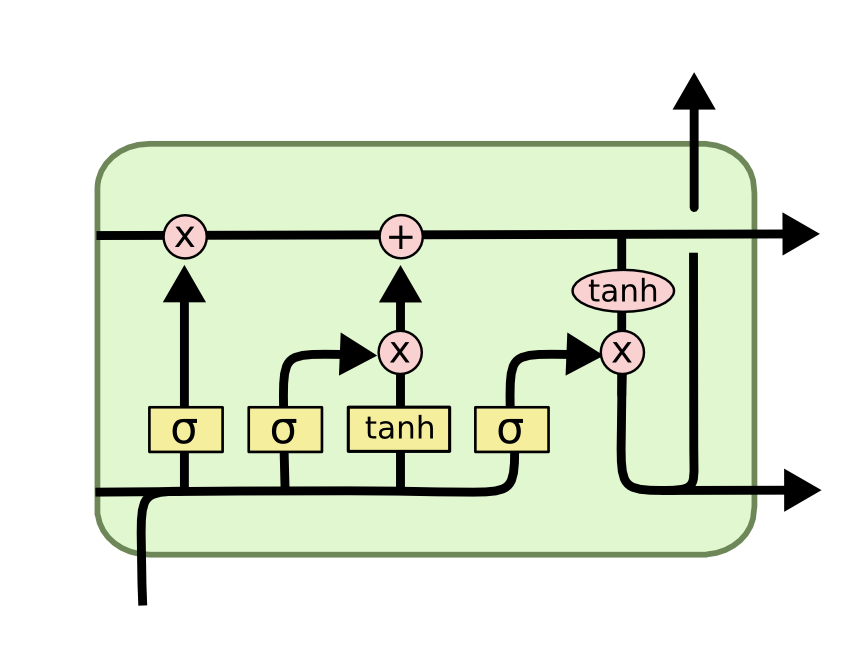

In [24]:
Image (filename="imgs/lstm.png", retina=True)

Run the following block to check your implementation

If you want to see nn.Parameter in example, check out this [tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) from PyTorch. Run the following block to check your implementation.

Note that in this case we are implementing a full loop with LSTM, iterating over each time step. The test cases reflect this as there are multiple sequences.

In [38]:
from models.naive.LSTM import LSTM

set_seed_nb()
'''
x1=
array([[-1., -1.],
       [ 1.,  1.],
       [ 3.,  3.]])

x2=
array([[-1.,  4.],
       [-1.,  4.],
       [-1.,  4.]])
'''
x1,x2 = np.mgrid[-1:3:3j, -1:4:2j]
'''
h1=
array([[-2., -2., -2., -2.],
       [ 0.,  0.,  0.,  0.],
       [ 2.,  2.,  2.,  2.]])

h2=
array([[1.        , 1.66666667, 2.33333333, 3.        ],
       [1.        , 1.66666667, 2.33333333, 3.        ],
       [1.        , 1.66666667, 2.33333333, 3.        ]])
'''
h1,h2 = np.mgrid[-2:2:3j, 1:3:4j]
batch = 4

# torch.Size([4, 3, 2])
# (batch size, sequence length, input_size)
x = torch.FloatTensor(np.linspace(x1,x2,batch))

# torch.Size([4, 3, 4])
# (batch size, sequence length, hidden_size)
h = torch.FloatTensor(np.linspace(h1,h2,batch))

expected_ht, expected_ct = unit_test_values('lstm')

#              2             4
lstm = LSTM(x.shape[-1], h.shape[-1])
deterministic_init(lstm)

# (h length 4, batch_size 4)
# (c length 4, batch_size 4)
h_t, c_t = lstm.forward(x)

if h_t is not None:
    print('Close to h_t: ', expected_ht.allclose(h_t, atol=1e-3))
    print('Close to c_t; ', expected_ct.allclose(c_t, atol=1e-3))
else:
    print("NOT IMPLEMENTED")

Close to h_t:  True
Close to c_t;  True


# **3: Train a Seq2Seq Model**
In this section, you will be working on implementing a simple Seq2Seq model. You will first implement an Encoder and a Decoder, and then join them together with a Seq2Seq architecture. You will need to complete the code in *Decoder.py*, *Encoder.py*, and *Seq2Seq.py* under *seq2seq* folder. Please refer to the instructions in those files.

## **3.1: Implement the Encoder**
In this section you will be implementing an RNN/LSTM based encoder to model German texts. Please refer to the instructions in *seq2seq/Encoder.py*. Run the following block to check your implementation.

In [ ]:
from models.seq2seq.Encoder import Encoder

set_seed_nb()
i, n, h = 10, 4, 2

encoder = Encoder(i, n, h, h)
x_array = np.random.rand(5,2) * 10
x = torch.LongTensor(x_array)
out, hidden = encoder.forward(x)

expected_out, expected_hidden = unit_test_values('encoder')

if out is not None:
    print('Close to out: ', expected_out.allclose(out, atol=1e-3))
    print('Close to hidden: ', expected_hidden.allclose(hidden, atol=1e-3))
else:
    print("NOT IMPLEMENTED")

## **3.2: Implement the Decoder**
In this section you will be implementing an RNN/LSTM based decoder to model English texts. Please refer to the instructions in *seq2seq/Decoder.py*. Run the following block to check your implementation.

In [ ]:
from models.seq2seq.Decoder import Decoder

set_seed_nb()
i, n, h =  10, 2, 2
decoder = Decoder(h, n, n, i)
x_array = np.random.rand(5, 2) * 10
x = torch.LongTensor(x_array[:,0]).unsqueeze(1) #decoder input is the first sequence
enc_out, enc_hidden = unit_test_values('encoder')
out, hidden = decoder.forward(x,enc_hidden)

expected_out, expected_hidden = unit_test_values('decoder')
if out is not None:
    print('Close to out: ', expected_out.allclose(out, atol=1e-3))
    print('Close to hidden: ', expected_hidden.allclose(hidden, atol=1e-3))
else:
    print("NOT IMPLEMENTED")

We will integrate a basic form of attention to assess its influence on our model's performance. Specifically, we will incorporate cosine similarity as the attention mechanism in decoder.py, as illustrated in the accompanying diagram. Additionally, for our straightforward attention mechanism, we employ a distinct context vector.

In [ ]:
Image (filename="imgs/attention.drawio.png", retina=True)

In [ ]:
#test computing attention probabilities
set_seed_nb()
hidden, enc_out, expected_attention_prob = unit_test_values('attention')
attention_prob=decoder.compute_attention(hidden, enc_out)

if attention_prob is not None:
  print('Close to attention_prob: ', expected_attention_prob.allclose(attention_prob, atol=1e-3))
else:
    print("NOT IMPLEMENTED")

## **3.3: Implement the Seq2Seq**
In this section you will be implementing the Seq2Seq model that utilizes the Encoder and Decoder you implemented. Please refer to the instructions in *seq2seq/Seq2Seq.py*. Run the following block to check your implementation.

In [ ]:
from models.seq2seq.Seq2Seq import Seq2Seq

set_seed_nb()
embedding_size = 32
hidden_size = 32
input_size = 8
output_size = 8
batch, seq = 2, 2

encoder = Encoder(input_size, embedding_size, hidden_size, hidden_size)
decoder = Decoder(embedding_size, hidden_size, hidden_size, output_size)

seq2seq = Seq2Seq(encoder, decoder, 'cpu')
x_array = np.random.rand(batch, seq) * 10
x = torch.LongTensor(x_array)
out = seq2seq.forward(x)

if out is not None:
    expected_out = unit_test_values('seq2seq')
    print('Close to out: ', expected_out.allclose(out, atol=1e-3))
else:
    print("NOT IMPLEMENTED")

# now lets test seq2seq with attention
decoder = Decoder(embedding_size, hidden_size, hidden_size, output_size, attention=True)
seq2seq = Seq2Seq(encoder, decoder, 'cpu')
out_attention = seq2seq.forward(x)

if out_attention is not None:
    expected_out = unit_test_values('seq2seq_attention')
    print('Close to out_attention: ', expected_out.allclose(out_attention, atol=1e-3))
else:
    print("SEQ2SEQ ATTENTION NOT IMPLEMENTED")


## **3.4: Train your Seq2Seq model**
Now it's time to combine what we have and train a Seq2Seq translator. We provided you with some training code and you can simply run them to see how your translator works. If you implemented everything correctly, you should see some meaningful translation in the output. You can modify the hyperparameters to improve the results. You can also tune the BATCH_SIZE in section 1.2.

In [ ]:
# Hyperparameters. You are welcome to modify these
encoder_emb_size = 128
encoder_hidden_size = 128
encoder_dropout = 0.2

decoder_emb_size = 128
decoder_hidden_size = 128
decoder_dropout = 0.2

learning_rate = 1e-3
model_type = "RNN"

EPOCHS = 20

#input size and output size
input_size = len(de_vocab)
output_size = len(en_vocab)

In [ ]:
# Declare models, optimizer, and loss function
set_seed_nb()
encoder = Encoder(input_size, encoder_emb_size, encoder_hidden_size, decoder_hidden_size, dropout = encoder_dropout, model_type = model_type)
decoder = Decoder(decoder_emb_size, encoder_hidden_size, encoder_hidden_size, output_size, dropout = decoder_dropout, model_type = model_type, attention=False)
seq2seq_model = Seq2Seq(encoder, decoder, device)

optimizer = optim.Adam(seq2seq_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
def train_and_plot (model, optimizer, scheduler, criterion, filename):
  train_perplexity_history = []
  valid_perplexity_history = []

  for epoch_idx in range(EPOCHS):
      print("-----------------------------------")
      print("Epoch %d" % (epoch_idx+1))
      print("-----------------------------------")

      train_loss, avg_train_loss = train(model, train_loader, optimizer, criterion, device=device)
      scheduler.step(train_loss)

      val_loss, avg_val_loss = evaluate(model, valid_loader, criterion, device=device)

      train_perplexity_history.append(np.exp(avg_train_loss))
      valid_perplexity_history.append(np.exp(avg_val_loss))

      print("Training Loss: %.4f. Validation Loss: %.4f. " % (avg_train_loss, avg_val_loss))
      print("Training Perplexity: %.4f. Validation Perplexity: %.4f. " % (np.exp(avg_train_loss), np.exp(avg_val_loss)))

  plot_curves(train_perplexity_history, valid_perplexity_history, filename)

In [ ]:
import time
start_time = time.time()
filename='seq2seq_model'
train_and_plot(seq2seq_model, optimizer, scheduler, criterion, filename)
end_time = time.time()
print("Time taken:", (end_time - start_time)/60)

# **4: Train a Transformer**

We will be implementing a one-layer Transformer **encoder** which, similar to an RNN, can encode a sequence of inputs and produce a final output of possibility of tokens in target language. This is the architecture:

In [ ]:
Image(filename="imgs/encoder.png")

You can refer to the [original paper](https://arxiv.org/pdf/1706.03762.pdf) for more details.

## The Corpus of Linguistic Acceptability (CoLA)

The Corpus of Linguistic Acceptability ([CoLA](https://nyu-mll.github.io/CoLA/)) in its full form consists of 10657 sentences from 23 linguistics publications, expertly annotated for acceptability (grammaticality) by their original authors. Native English speakers consistently report a sharp contrast in acceptability between pairs of sentences.
Some examples include:

`What did Betsy paint a picture of?` (Correct)

`What was a picture of painted by Betsy?` (Incorrect)

You can read more info about the dataset [here](https://arxiv.org/pdf/1805.12471.pdf). This is a binary classification task (predict 1 for correct grammar and 0 otherwise).

We will be using this dataset as a sanity checker for the forward pass of the Transformer architecture discussed in class. The general intuitive notion is that we will _encode_ the sequence of tokens in the sentence, and then predict a binary output based on the final state that is the output of the model.

## Load the preprocessed data

We've appended a "SOS" token to the beginning of each sequence, which can be used to make predictions. The benefit of appending this token to the beginning of the sequence is that we can extract it quite easily .

We've additionally already constructed a vocabulary and converted all of the strings of tokens into integers which can be used for vocabulary lookup for you. Feel free to explore the data here.

In [ ]:
train_inxs = np.load('./data/train_inxs.npy')
val_inxs = np.load('./data/val_inxs.npy')
train_labels = np.load('./data/train_labels.npy')
val_labels = np.load('./data/val_labels.npy')

# load dictionary
word_to_ix = {}
with open("./data/word_to_ix.csv", "r", encoding='utf-8') as f:
    reader = csv.reader(f)
    for line in reader:
        word_to_ix[line[0]] = line[1]
print("Vocabulary Size:", len(word_to_ix))

print(train_inxs.shape) # 7000 training instances, of (maximum/padded) length 43 words.
print(val_inxs.shape) # 1551 validation instances, of (maximum/padded) length 43 words.
print(train_labels.shape)
print(val_labels.shape)

d1 = torch.load('./data/d1.pt')
d2 = torch.load('./data/d2.pt')
d3 = torch.load('./data/d3.pt')
d4 = torch.load('./data/d4.pt')

Instead of using numpy for this model, we will be using Pytorch to implement the forward pass. You will not need to implement the backward pass for the various layers in this assigment.

The file `models/Transformer.py` contains the model class and methods for each layer. This is where you will write your implementations.

## **4.1: Embeddings**

We will format our input embeddings similarly to how they are constructed in [BERT (source of figure)](https://arxiv.org/pdf/1810.04805.pdf). Recall from lecture that unlike a RNN, a Transformer does not include any positional information about the order in which the words in the sentence occur. Because of this, we need to append a positional encoding token at each position. (We will ignore the segment embeddings and [SEP] token here, since we are only encoding one sentence at a time). We have already appended the [SOS] token for you in the previous step.




In [ ]:
Image(filename="imgs/embedding.png")

Your first task is to implement the embedding lookup, including the addition of positional encodings. Open the file `Transformer.py` and complete all code parts for `Deliverable 1`.

In [ ]:
from models.Transformer import TransformerTranslator
inputs = train_inxs[0:2]
inputs = torch.LongTensor(inputs)

model = TransformerTranslator(input_size=len(word_to_ix), output_size=2, device=device, hidden_dim=128, num_heads=2, dim_feedforward=2048, dim_k=96, dim_v=96, dim_q=96, max_length=train_inxs.shape[1])

embeds = model.embed(inputs)

try:
    print("Difference:", torch.sum(torch.pairwise_distance(embeds, d1)).item()) # should be very small (<0.01)
except:
    print("NOT IMPLEMENTED")

## **4.2: Multi-head Self-Attention**

Attention can be computed in matrix-form using the following formula:

In [ ]:
Image(filename="imgs/attn.png")

We want to have multiple self-attention operations, computed in parallel. Each of these is called a *head*. We concatenate the heads and multiply them with the matrix `attention_head_projection` to produce the output of this layer.

After every multi-head self-attention and feedforward layer, there is a residual connection + layer normalization. Make sure to implement this, using the following formula:




In [ ]:
Image(filename="imgs/layer_norm.png")

Open the file `models/transformer.py` and implement the `multihead_attention` function.
We have already initialized all of the layers you will need in the constructor.

In [ ]:
hidden_states = model.multi_head_attention(embeds)

try:
    print("Difference:", torch.sum(torch.pairwise_distance(hidden_states, d2)).item()) # should be very small (<0.01)
except:
    print("NOT IMPLEMENTED")

## **4.3: Element-Wise Feed-forward Layer**

Open the file `models/transformer.py` and complete code for `Deliverable 3`: the element-wise feed-forward layer consisting of two linear transformers with a ReLU layer in between.




In [ ]:
Image(filename="imgs/ffn.png")

In [ ]:
outputs = model.feedforward_layer(hidden_states)

try:
    print("Difference:", torch.sum(torch.pairwise_distance(outputs, d3)).item()) # should be very small (<0.01)
except:
    print("NOT IMPLEMENTED")

## **4.4: Final Layer**

Open the file `models/transformer.py` and complete code for `Deliverable 4`, to produce scores for all tokens in target language.

In [ ]:
scores = model.final_layer(outputs)

try:
    print("Difference:", torch.sum(torch.pairwise_distance(scores, d4)).item()) # should be very small (<3e-4)
except:
    print("NOT IMPLEMENTED")

## **4.5: Putting it all together**

Open the file `models/transformer.py` and complete the method `forward`, by putting together all of the methods you have developed in the right order to perform a full forward pass.


In [ ]:
inputs = train_inxs[0:2]
inputs = torch.LongTensor(inputs)
inputs.to(device)
outputs = model.forward(inputs)

try:
    print("Difference:", torch.sum(torch.pairwise_distance(outputs, scores)).item()) # should be very small (<3e-4)
except:
    print("NOT IMPLEMENTED")

Great! We've just implemented a Transformer forward pass for translation. One of the big perks of using PyTorch is that with a simple training loop, we can rely on automatic differentation ([autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)) to do the work of the backward pass for us. This is not required for this assignment, but you can explore this on your own.

## **4.6: Train the Transformer**
Now you can start training the Transformer translator. We provided you with some training code and you can simply run them to see how your translator works. If you implemented everything correctly, you should see some meaningful translation in the output. Compare the results from the Seq2Seq model, which one is better? You can modify the hyperparameters to improve the results. You can also tune the BATCH_SIZE in section 1.2.

In [ ]:
# Hyperparameters
learning_rate = 1e-3
EPOCHS = 10

# Model
trans_model = TransformerTranslator(input_size, output_size, device, max_length = MAX_LEN).to(device)

# optimizer = optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(trans_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
import time
start_time = time.time()
filename='trans_model'
train_and_plot(trans_model, optimizer, scheduler, criterion, filename)
end_time = time.time()
print("Time taken:", (end_time - start_time)/60)

## **4.7: Implement and train a full transformer (encoder/decoder)**
<p align="center"><strong>This section is Optional for Summer Session</strong></p>
In the previous section, you implemented the encoder module of a transformer from scratch. In this section, you use pytorch built-in transformer module to build your translator model.
you can start training the Transformer translator. We provided you with some training code and you can simply run them to see how your translator works. If you implemented everything correctly, you should see some meaningful translation in the output. Compare the results from the transformer (encoder only) model, which one is better? You can modify the hyperparameters to improve the results. You can also tune the BATCH_SIZE in section 1.2.

In [ ]:
# @title
from models.Transformer import FullTransformerTranslator
# you will be implementing and testing the forward function here. During training, inaddition to inputs, targets are also passed to the forward function
set_seed_nb()
inputs = train_inxs[0:3]
inputs[:,0]=0
inputs = torch.LongTensor(inputs)
inputs.to('cpu')
# Model
full_trans_model = FullTransformerTranslator(input_size=len(word_to_ix), output_size=5, device='cpu', hidden_dim=128, num_heads=2, dim_feedforward=2048, max_length=train_inxs.shape[1]).to('cpu')

tgt_array = np.random.rand(inputs.shape[0], inputs.shape[1])
targets = torch.LongTensor(tgt_array)
targets.to('cpu')
outputs = full_trans_model.forward(inputs,targets)

if outputs is not None:
    expected_out = unit_test_values('full_trans_fwd')
    print('Close to outputs: ', expected_out.allclose(outputs, atol=1e-3))
else:
    print("NOT IMPLEMENTED")


In [ ]:
# you will be implementing the generate_translation function which is called at the time of interence to translate the inputs. This is done in an autoregressive manner very similar to how you implemented the seq2seq model earlier
inputs = train_inxs[3:6]
inputs[:,0]=0
inputs = torch.LongTensor(inputs)
inputs.to('cpu')
full_trans_model = FullTransformerTranslator(input_size=len(word_to_ix), output_size=5, device='cpu', hidden_dim=128, num_heads=2, dim_feedforward=2048, max_length=train_inxs.shape[1]).to('cpu')
outputs = full_trans_model.generate_translation(inputs)

if outputs is not None:
    expected_out = unit_test_values('full_trans_translate')
    print('Close to outputs: ', expected_out.allclose(outputs, atol=1e-3))
else:
    print("NOT IMPLEMENTED")


In [ ]:
# Hyperparameters
learning_rate = 1e-3
EPOCHS = 10

# Model
full_trans_model = FullTransformerTranslator(input_size, output_size, device, max_length = MAX_LEN, ignore_index=PAD_IDX).to(device)

optimizer = torch.optim.Adam(full_trans_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
import time
start_time = time.time()
filename='full_trans_model'
train_and_plot(full_trans_model, optimizer, scheduler, criterion, filename)
end_time = time.time()
print("Time taken:", (end_time - start_time)/60)

# **Translations**

Run the code below to see some of your translations. Modify to your liking.

In [ ]:
def translate(model, dataloader):
    model.eval()
    with torch.no_grad():
        # Get the progress bar
        progress_bar = tqdm(dataloader, ascii = True)
        for batch_idx, data in enumerate(progress_bar):
            source = data[0].transpose(1,0).to(device)
            target = data[1].transpose(1,0).to(device)
            if model.__class__.__name__ == 'FullTransformerTranslator':
                translation = model.generate_translation(source)
            else:
                translation = model(source)
            return target, translation

In [ ]:
# Select Transformer or Seq2Seq model
#model = trans_model
#model = seq2seq_model
model = full_trans_model

In [ ]:
#Set model equal to trans_model or seq2seq_model
target, translation = translate(model, test_loader)

In [ ]:
# Get the expected English translations
raw = np.array([
    list(map(lambda x: en_vocab.get_itos()[int(x)] if int(x) in en_vocab.get_itos() else '<unk>', target[i]))
    for i in range(target.shape[0])
])

In [ ]:
raw[0:9]

In [ ]:
#Get the predicted English translations for comparison
token_trans = np.argmax(translation.cpu().numpy(), axis = 2)
translated = np.array([list(map(lambda x: en_vocab.get_itos()[x], token_trans[i])) for i in range(token_trans.shape[0])])

In [ ]:
translated[0:9]